## Project Title: Predicting Customer Churn

This project aims to predict whether a customer will leave the company (churn) based on customer behavior data.
We use a tabular dataset from [source].

The goal is to build a machine learning model that helps the business identify at-risk customers.

In [1]:
# Libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from IPython.display import Markdown, display
from sklearn.metrics import explained_variance_score
import time


df = pd.read_csv('/Users/suleimmen/Desktop/Project Into to ML/Dataset/cleaned_kz_data 2.csv')

<h1>This is a map of Kazakhstan with red dots marking the locations where apartments were sold<h1>

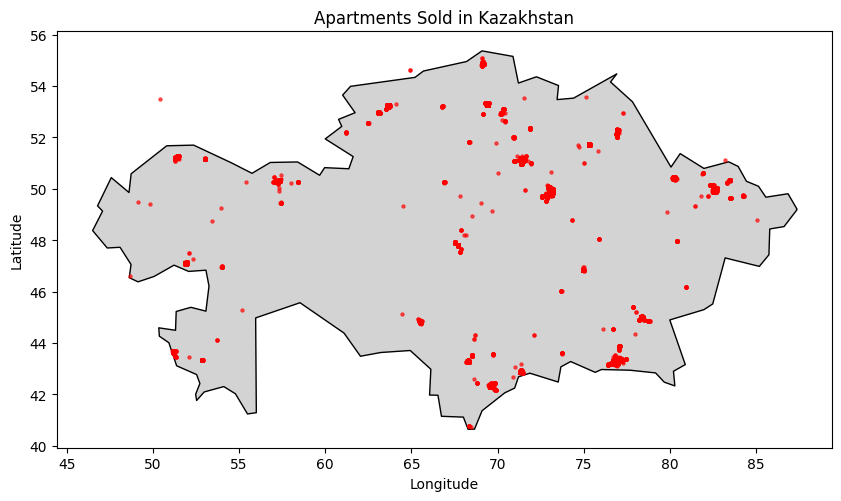

In [2]:
world = gpd.read_file("/Users/suleimmen/Desktop/Project Into to ML/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
kazakhstan = world[world['NAME'] == 'Kazakhstan']
df = df.dropna(subset=['map_lon', 'map_lat'])

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.map_lon, df.map_lat),
    crs='EPSG:4326'
)

fig, ax = plt.subplots(figsize=(10, 10))
kazakhstan.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, markersize=5, color='red', alpha=0.6)
plt.title('Apartments Sold in Kazakhstan')  
plt.xlabel('Longitude')                     
plt.ylabel('Latitude')                      
plt.show()


<h1>Preliminary analysis of data</h1>
<p>We will check the data for omissions and examine the distribution of numerical and categorical features.</p>

In [ ]:
# Quick look at the data
print(f"Size of Dataset: {df.shape}")
display(df.head())

Size of Dataset: (49728, 16)


,price,live_rooms,live_square,map_city,map_lat,map_lon,year,house_complex_name,flat_floor,house_floor_num,flat_building,flat_renovation,live_furniture,flat_toilet,mortgage,flat_priv_dorm
0,21500000,2,47,караганда,49.777852,73.138243,1972,349.0,4.0,5.0,2.0,1.0,2.0,2.0,0.0,2.0
1,58600000,4,108,караганда,49.779672,73.132440,2020,1171.0,1.0,10.0,1.0,1.0,1.0,3.0,0.0,2.0
2,38500000,2,71,караганда,49.797291,73.142052,2021,1976.0,2.0,10.0,1.0,1.0,2.0,2.0,0.0,2.0
3,9000000,2,44,караганда,49.807940,73.054736,1955,177.0,1.0,5.0,1.0,1.0,2.0,1.0,0.0,2.0
4,22880000,3,88,караганда,49.778597,73.059382,2025,2408.0,3.0,5.0,1.0,5.0,3.0,1.0,0.0,2.0


In [4]:
# Descriptive statistics table
describe = df.describe().T
describe['mean'] = describe['mean'].apply(lambda x: '{:.2f}'.format(x))
describe['std'] = describe['std'].apply(lambda x: '{:.2f}'.format(x))
describe['max'] = describe['max'].apply(lambda x: '{:.2f}'.format(x))
describe['count'] = describe['count'].astype('int')

# Display descriptive statistics
print("\n📊 Descriptive statistics of the data:")
display(describe)



📊 Descriptive statistics of the data:


,count,mean,std,min,25%,50%,75%,max
price,49728,27949670.09,15337544.52,8.900000e+06,1.670000e+07,2.400000e+07,3.500000e+07,85000000.00
live_rooms,49728,2.26,0.90,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.00
live_square,49728,62.20,24.73,1.100000e+01,4.500000e+01,5.800000e+01,7.300000e+01,280.00
map_lat,49728,48.15,3.97,4.073229e+01,4.330889e+01,4.995574e+01,5.114673e+01,55.09
map_lon,49728,69.73,8.89,4.864900e+01,6.547155e+01,7.143292e+01,7.687676e+01,85.09
year,49728,2000.53,21.06,1.913000e+03,1.981000e+03,2.008000e+03,2.020000e+03,2025.00
house_complex_name,49728,1622.30,867.59,1.000000e+00,1.008000e+03,1.601000e+03,2.224000e+03,3492.00
flat_floor,49728,4.70,3.28,0.000000e+00,2.000000e+00,4.000000e+00,6.000000e+00,60.00
house_floor_num,49728,7.73,4.03,1.000000e+00,5.000000e+00,6.000000e+00,9.000000e+00,59.00
flat_building,49728,1.90,0.80,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.00


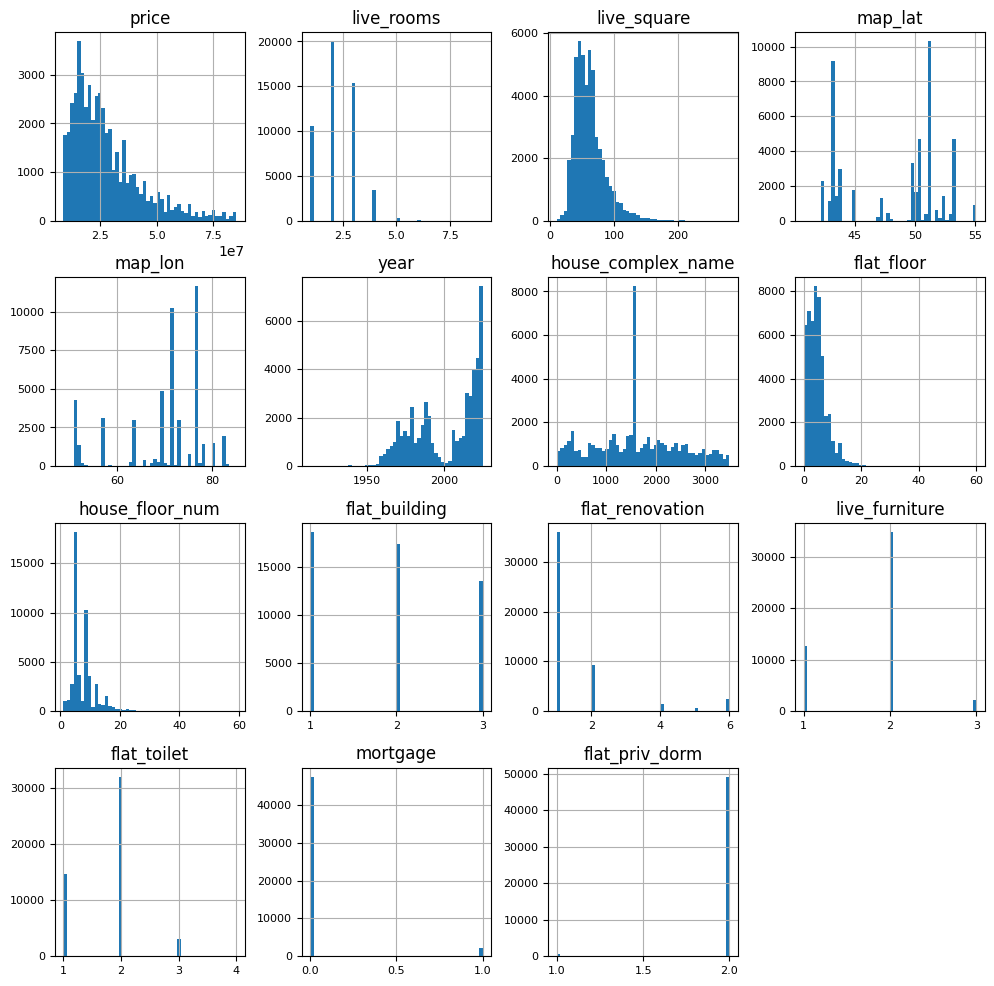

In [5]:
df.hist(figsize=(12, 12), bins=50, xlabelsize=8, ylabelsize=8);

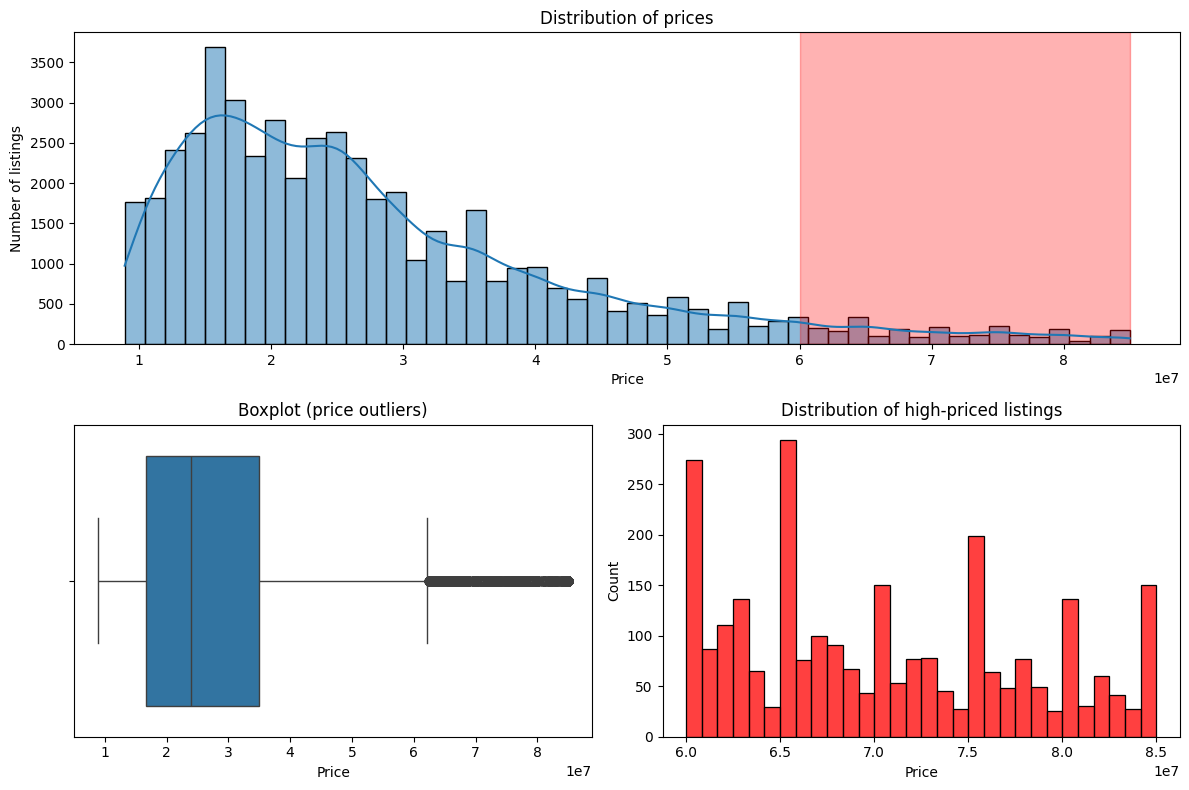

In [6]:
# Visualization of price distribution
fig = plt.figure(figsize=(12, 8))

# Price histogram (top wide plot)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
sns.histplot(data=df, x='price', bins=50, kde=True, ax=ax1)
ax1.axvspan(df['price'].quantile(0.95), df['price'].max(), color='red', alpha=0.3)
ax1.set_title('Distribution of prices')
ax1.set_xlabel('Price')
ax1.set_ylabel('Number of listings')

# Boxplot to detect outliers (bottom left)
ax2 = plt.subplot2grid((2, 2), (1, 0))
sns.boxplot(data=df, x='price', ax=ax2)
ax2.set_title('Boxplot (price outliers)')
ax2.set_xlabel('Price')

# Histogram of expensive listings (>95 percentile) (bottom right)
ax3 = plt.subplot2grid((2, 2), (1, 1))
high_prices = df[df['price'] >= df['price'].quantile(0.95)]
sns.histplot(data=high_prices, x='price', bins=30, color='red', ax=ax3)
ax3.set_title('Distribution of high-priced listings')
ax3.set_xlabel('Price')
ax3.set_ylabel('Count')

plt.tight_layout()
plt.show()


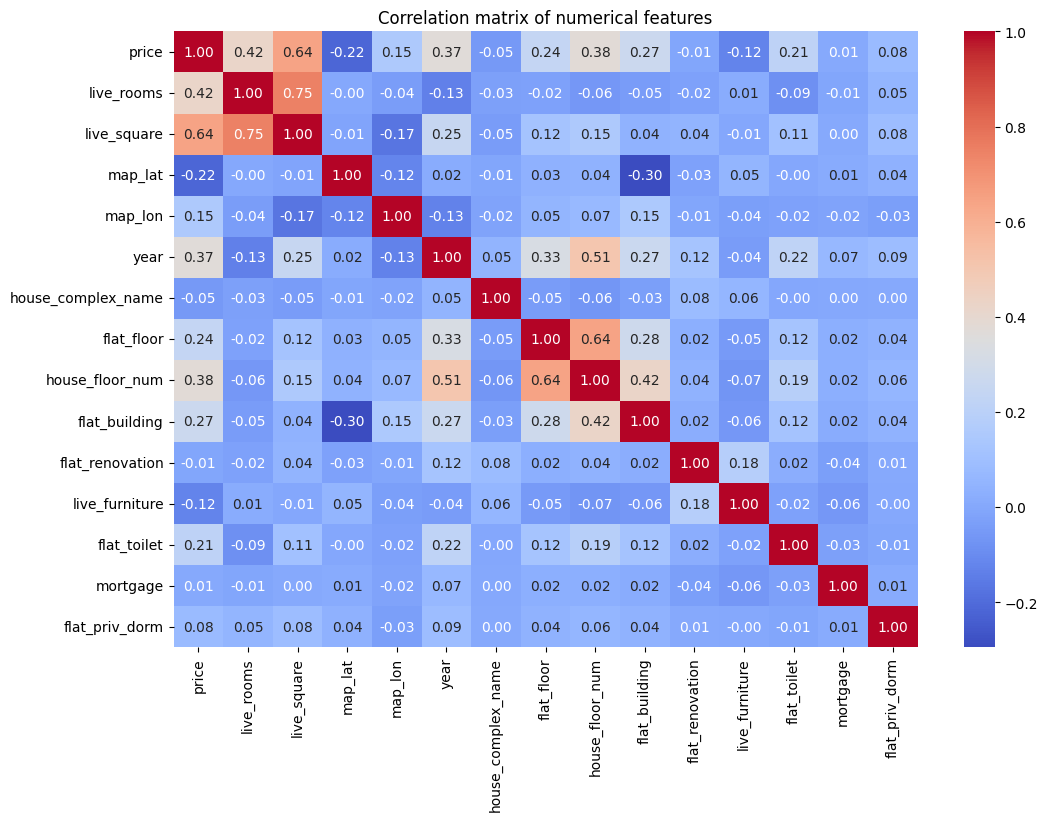

In [7]:
# Correlation analysis between numeric features
df_numeric = df.select_dtypes(include=['number'])
correlation_matrix = df_numeric.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix of numerical features")
plt.show()


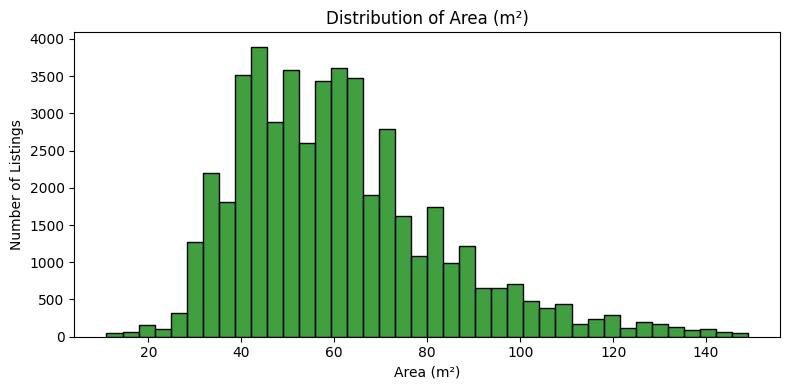

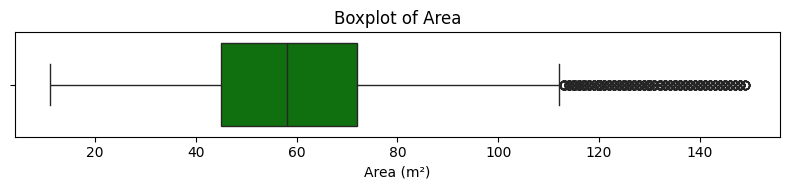

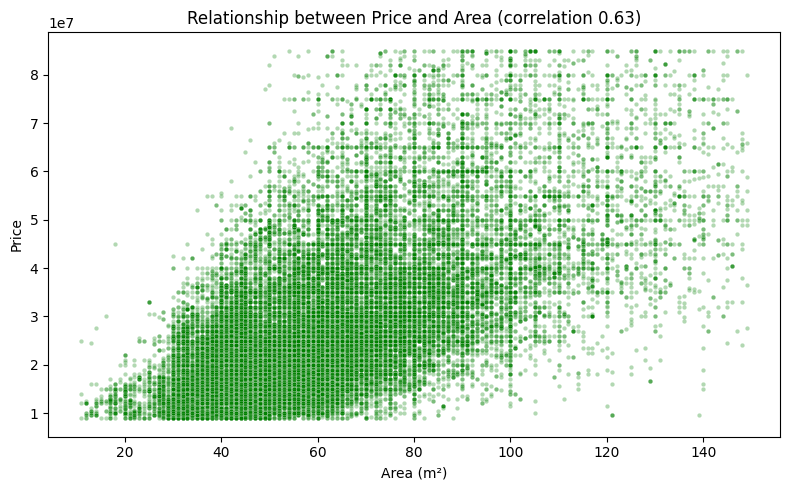

In [8]:
filtered_df = df[df['live_square'] < 150]

# 1. Histogram of area distribution
plt.figure(figsize=(8, 4))
sns.histplot(data=filtered_df, x='live_square', bins=40, color='green')
plt.title('Distribution of Area (m²)')
plt.xlabel('Area (m²)')
plt.ylabel('Number of Listings')
plt.tight_layout()
plt.show()

# 2. Boxplot to detect emissions
plt.figure(figsize=(8, 2))
sns.boxplot(data=filtered_df, x='live_square', color='green')
plt.title('Boxplot of Area')
plt.xlabel('Area (m²)')
plt.tight_layout()
plt.show()

# 3. Scatterplot: price dependence on area
plt.figure(figsize=(8, 5))
sns.scatterplot(data=filtered_df, x='live_square', y='price', color='green', alpha=0.3, s=10)
corr_value = filtered_df[['live_square', 'price']].corr().iloc[0, 1]
plt.title(f'Relationship between Price and Area (correlation {corr_value:.2f})')
plt.xlabel('Area (m²)')
plt.ylabel('Price')
plt.tight_layout()
plt.show()



/var/folders/r1/ffz_5w253yz25hbl4kz193r00000gn/T/ipykernel_2251/12737633.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


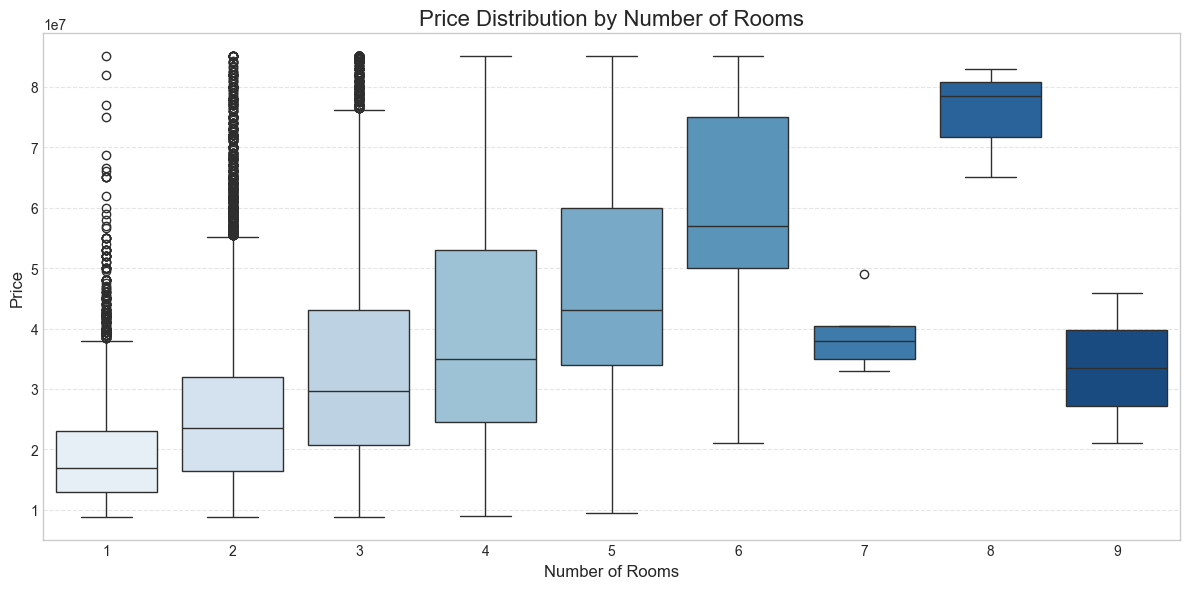

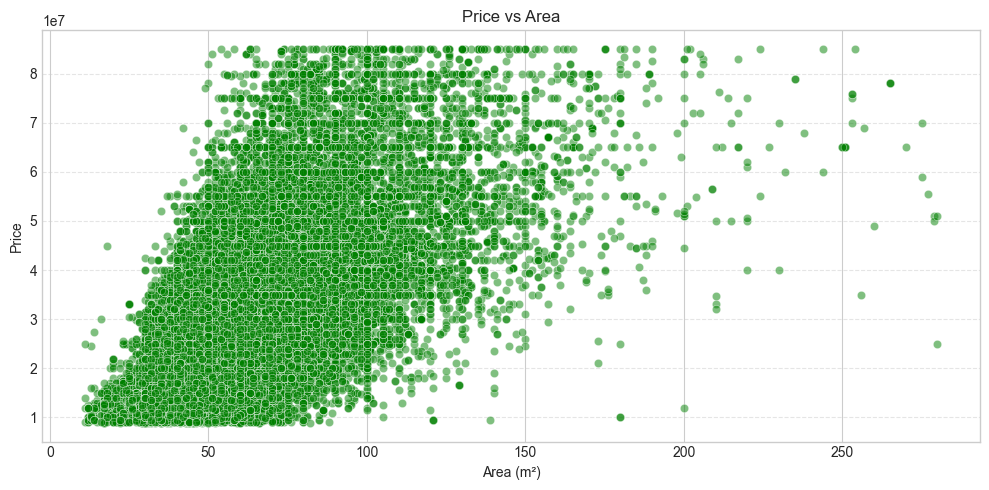

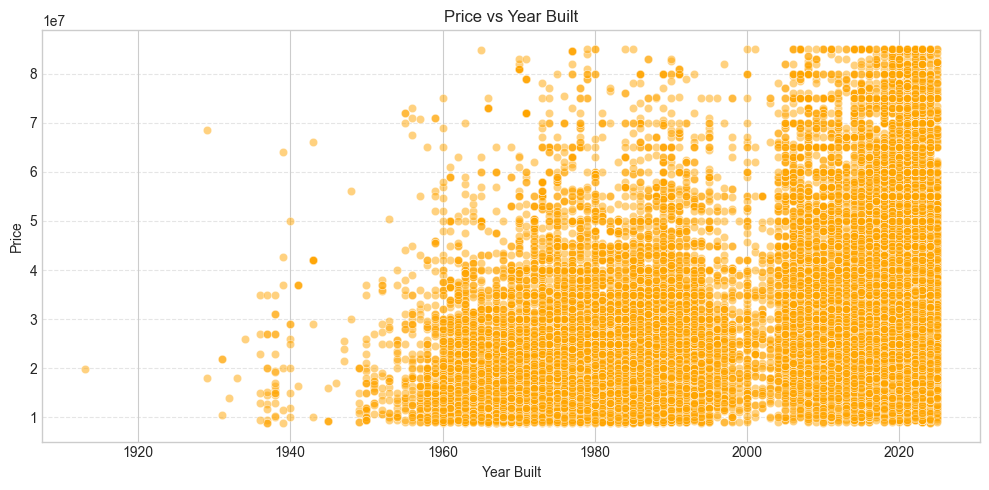

/var/folders/r1/ffz_5w253yz25hbl4kz193r00000gn/T/ipykernel_2251/12737633.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_by_floors, x='house_floor_num', y='price', palette='coolwarm')


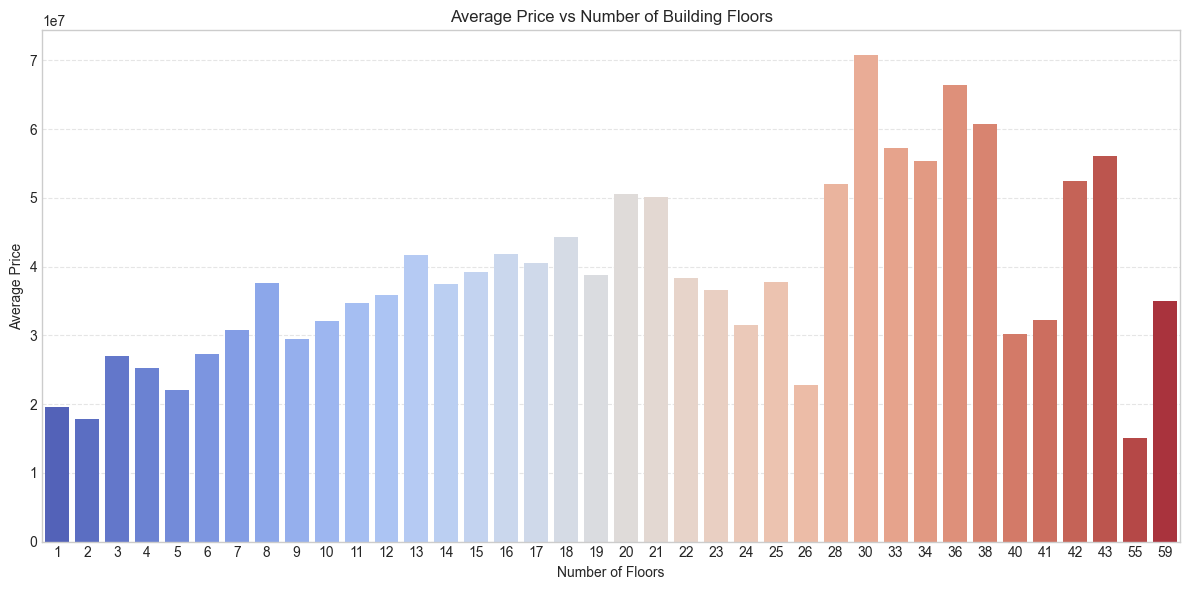

In [27]:
# Chart 1 - Price vs Number of Rooms
filtered_df = df[['live_rooms', 'price']].dropna()
filtered_df['live_rooms'] = filtered_df['live_rooms'].astype(int)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=filtered_df,
    x='live_rooms',
    y='price',
    palette='Blues',
    showfliers=True  
)

plt.title('Price Distribution by Number of Rooms', fontsize=16)
plt.xlabel('Number of Rooms', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()



# Chart 2 - Scatterplot: Price vs Area
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='live_square', y='price', color='green', alpha=0.5)
plt.title('Price vs Area')
plt.xlabel('Area (m²)')
plt.ylabel('Price')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Chart 3 - Scatterplot: Price vs Year Built
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='year', y='price', color='orange', alpha=0.5)
plt.title('Price vs Year Built')
plt.xlabel('Year Built')
plt.ylabel('Price')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Chart 4 - Average price depending on the number of floors in the building
plt.figure(figsize=(12, 6))
df['house_floor_num'] = df['house_floor_num'].astype(int)
avg_price_by_floors = df.groupby('house_floor_num')['price'].mean().reset_index()

sns.barplot(data=avg_price_by_floors, x='house_floor_num', y='price', palette='coolwarm')
plt.title('Average Price vs Number of Building Floors')
plt.xlabel('Number of Floors')
plt.ylabel('Average Price')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Preparing data for modeling

Before training a model, it is important to train the data correctly. This is the basis for **quality** and **stable** prediction.

---

## Classic data preparation process

Here are the standard steps you almost always go through when working with data:

| **Step** | **What are we doing?** | **Why?** |
|---------------------------------|-------------------------------------|------------------------------------------------|
| **Missing Values** | Fill in/mark/delete | The model cannot work with empty cells |
|  **Extremes** | Look for extreme values | Remove errors or leave important anomalies |
| **Categorical attributes** | Turning text into numbers (encoding) | The model doesn't understand textual values |
| **Scaling** | Normalize numeric features | For scale-sensitive algorithms |
| **Data splitting** | On train/test (e.g., 80/20) | To test the model on new examples |
---

## Our focus right now:

**Codify** `map_city`.  
**Separate** the data into **train / test**

---

**Why is this important?

- **Unprepared** data can be misleading to the model  
- **Clean data** gives **better results** than complex models on “dirty” data  
- It is important to **understand** what we are doing and **why** we are doing it at each step.

---


## Categorical feature coding with Target Encoding

> **Target**  
> Translate categorical attributes into numeric form so that the model can work with them.  
> Instead of the usual replacement by numbers, we use **Target Encoding** - it takes into account the relationship of the feature to the price of the apartment.


<img src="https://fv5-4.files.fm/thumb_show.php?i=unjjpda543&view&v=1&PHPSESSID=be0031b27fc7389a2bb93dd5bd00dd7ae0d21c96" alt="Python Data Science Libraries" width="700"/>

### How does it work?

Each category (city) is replaced by the **average price** for that city.

This helps the model understand the **influence of the city on real estate values**.

---

**Why Target Encoding?**
- Accounts for the influence of categories on the target variable (price).  
- Works well with tree-based algorithms (Decision Tree, Random Forest, LightGBM).  
- Especially useful when there are many unique categories and it is difficult to use One-Hot Encoding.

**Important:**  
We count averages **only on the training sample** to avoid data leakage.

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Size of training sample: {X_train.shape}")
print(f"Size of test sample: {X_test.shape}")

Size of training sample: (39782, 15)
Size of test sample: (9946, 15)


In [11]:
# Keeping the original values for the “before/after” example
original_cities = X_train[['map_city']].copy()

# Create Target Encoder
target_encoder = ce.TargetEncoder(cols=['map_city'])

# Fitim encoder on the training sample
X_train['map_city'] = target_encoder.fit_transform(X_train['map_city'], y_train)

# Transforming the test sample
X_test['map_city'] = target_encoder.transform(X_test['map_city'])

# Create a table to display “before / after” coding
encoding_comparison = original_cities.copy()
encoding_comparison['map_city_encoded'] = X_train['map_city']

# We only take the top 10 rows to display
encoding_comparison_display = encoding_comparison.head(10).reset_index(drop=True)

print("\nTable of categories before and after Target Encoding (top 10):")
display(encoding_comparison_display)


Table of categories before and after Target Encoding (top 10):


,map_city,map_city_encoded
0,атырау,2.755648e+07
1,астана,3.265137e+07
2,жезказган,1.971637e+07
3,алматы,4.078889e+07
4,усть-каменогорск,2.365217e+07
5,астана,3.265137e+07
6,астана,3.265137e+07
7,аягоз,1.924129e+07
8,жезказган,1.971637e+07
9,талдыкорган,2.065651e+07


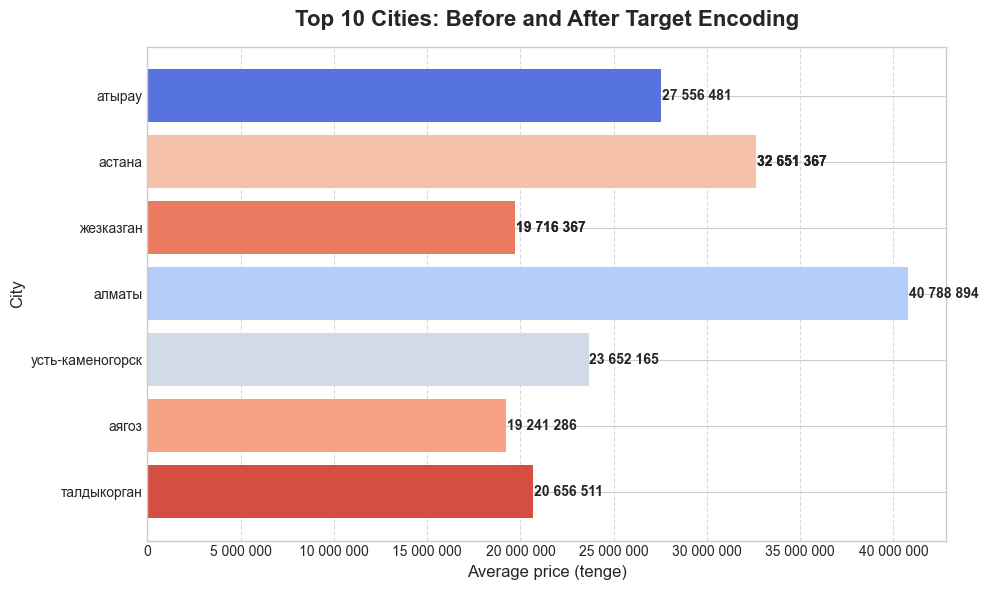

In [12]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))

colors = sns.color_palette("coolwarm", len(encoding_comparison_display))

bars = ax.barh(encoding_comparison_display['map_city'],
               encoding_comparison_display['map_city_encoded'],
               color=colors)

# Add captions to the values
for bar in bars:
    width = bar.get_width()
    ax.text(width + 50000,
            bar.get_y() + bar.get_height() / 2,
            f'{int(width):,}'.replace(',', ' '),
            va='center',
            fontsize=10,
            fontweight='bold')

ax.set_title('Top 10 Cities: Before and After Target Encoding', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Average price (tenge)', fontsize=12)
ax.set_ylabel('City', fontsize=12)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))
ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## The data has been successfully trained!
Now they are ready for model training

## Train models

Let's build three models: decision tree, random forest, and LightGBM.
Let's check their accuracy, compare metrics and visualize the importance of features.

## Decision Tree

In [13]:
dt_model = DecisionTreeRegressor(
    max_depth=10,             # maximum depth of the tree (so that it does not go too deep and overtrain)
    min_samples_split=5,      # minimum number of objects to do the partitioning (the more - the more “careful” the tree is)
    min_samples_leaf=10,      # minimum number of objects in the worksheet (final answer), helps to avoid overtraining
    random_state=42           # capture the randomness so that the result can be repeated
)
start_time = time.time()
dt_model.fit(X_train, y_train)
train_time_dt = time.time() - start_time
y_pred_dt = dt_model.predict(X_test)

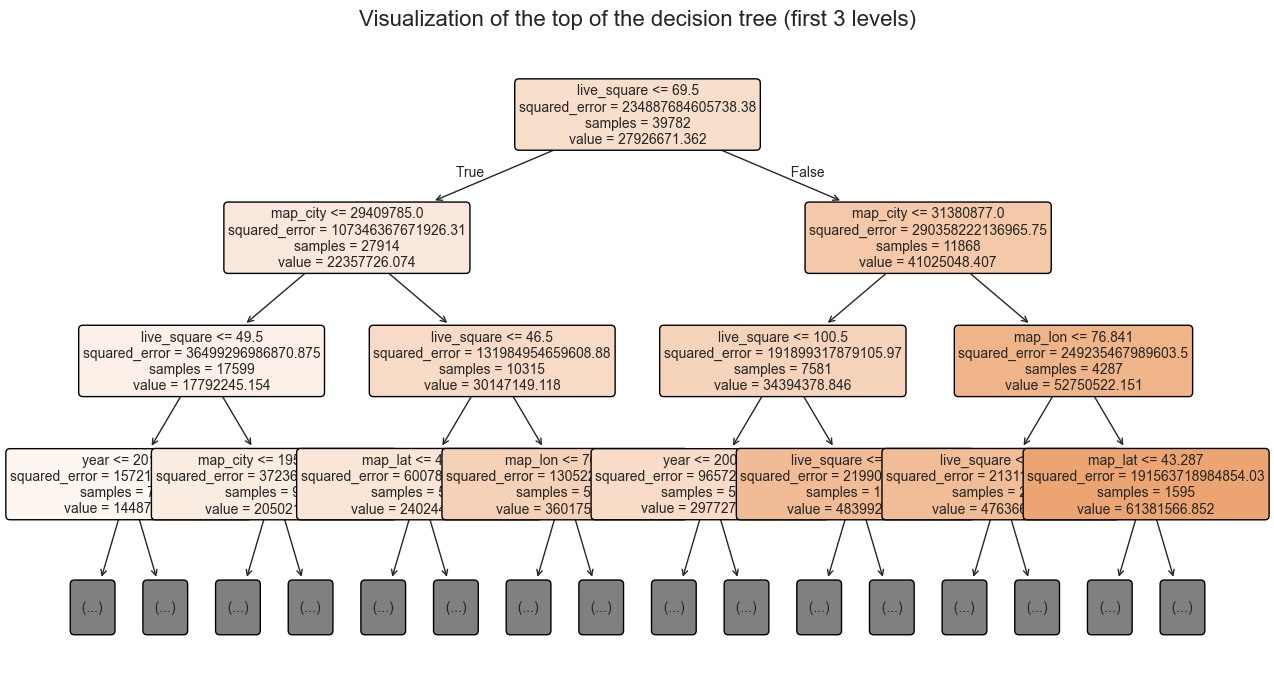

In [14]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

plot_tree(
    dt_model,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    max_depth=3,                   # Show only the top of the tree (3 levels)
    fontsize=10
)

plt.title('Visualization of the top of the decision tree (first 3 levels)', fontsize=16, pad=20)
plt.show()


## Random Forest

<img src="https://miro.medium.com/max/1400/1*Lug3F9M8qIjatjCQR5R1xA.png" alt="Python Data Science Libraries" width="700"/>

In [15]:
# Training a random forest model
rf_model = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=5,
                                min_samples_leaf=4, random_state=42, n_jobs=-1)

start_time = time.time()
rf_model.fit(X_train, y_train)
train_time_rf = time.time() - start_time
y_pred_rf = rf_model.predict(X_test)

## Boosting (LightGBM)

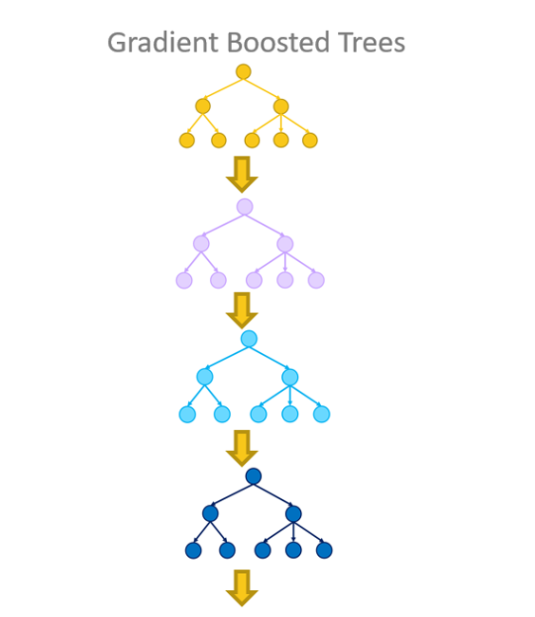

<div style="display: flex; justify-content: space-between; align-items: center;">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*OZPOQUKiaVmZOEMm_-8iYA.png" alt="Бустинг по ссылке" width="48%" style="border-radius: 10px;"/>
</div>

In [16]:
# LightGBM model training
lgbm_model = LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=10,
                          num_leaves=31, min_child_samples=20, random_state=42)
start_time = time.time()
lgbm_model.fit(X_train, y_train)
train_time_lgbm = time.time() - start_time
y_pred_lgbm = lgbm_model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1234
[LightGBM] [Info] Number of data points in the train set: 39782, number of used features: 15
[LightGBM] [Info] Start training from score 27926671.366975



# Model Evaluation Metrics

To evaluate the quality of regression models, we will use the following metrics:

---

### 1. **MAE (Mean Absolute Error)**

- **What is it?** The average absolute deviation of the predicted price from the actual one  
- **How to interpret it?** For example, MAE = 10,000 means that, on average, the model is off by 10,000 rubles/dollars  
- **The lower, the better!**

---

### 2. **MSE (Mean Squared Error)**

- **What is it?** The average of the squared differences between the predicted and actual prices  
- **How to interpret it?** Penalizes large errors more heavily than small ones  
- **The lower, the better!**

---

### 3. **RMSE (Root Mean Squared Error)**

- **What is it?** The square root of the MSE; it has the same units as the predicted value (e.g. price)  
- **How to interpret it?** Similar to MAE but gives more weight to large errors  
- **The lower, the better!**

---

### 4. **R² (Coefficient of Determination)**

- **What is it?** Shows the proportion of price variance explained by the model  
- **How to interpret it?** R² = 0.75 means the model explains 75% of the price variation  
- **The closer to 1, the better!** (An ideal model has R² = 1)


In [17]:
# Оценка качества моделей
models = {
    'Decision tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'LightGBM': y_pred_lgbm
}

results = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'R²'])

for name, predictions in models.items():
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    results.loc[name] = [mae, mse, rmse, r2]

display(results)


,MAE,MSE,RMSE,R²
Decision tree,4.188535e+06,3.787942e+13,6.154626e+06,0.839912
Random Forest,3.733685e+06,2.982483e+13,5.461212e+06,0.873953
LightGBM,3.353409e+06,2.437453e+13,4.937057e+06,0.896987


/var/folders/r1/ffz_5w253yz25hbl4kz193r00000gn/T/ipykernel_2251/4044291397.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results.index, rotation=45)
/var/folders/r1/ffz_5w253yz25hbl4kz193r00000gn/T/ipykernel_2251/4044291397.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results.index, rotation=45)
/var/folders/r1/ffz_5w253yz25hbl4kz193r00000gn/T/ipykernel_2251/4044291397.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results.index, rotation=45)


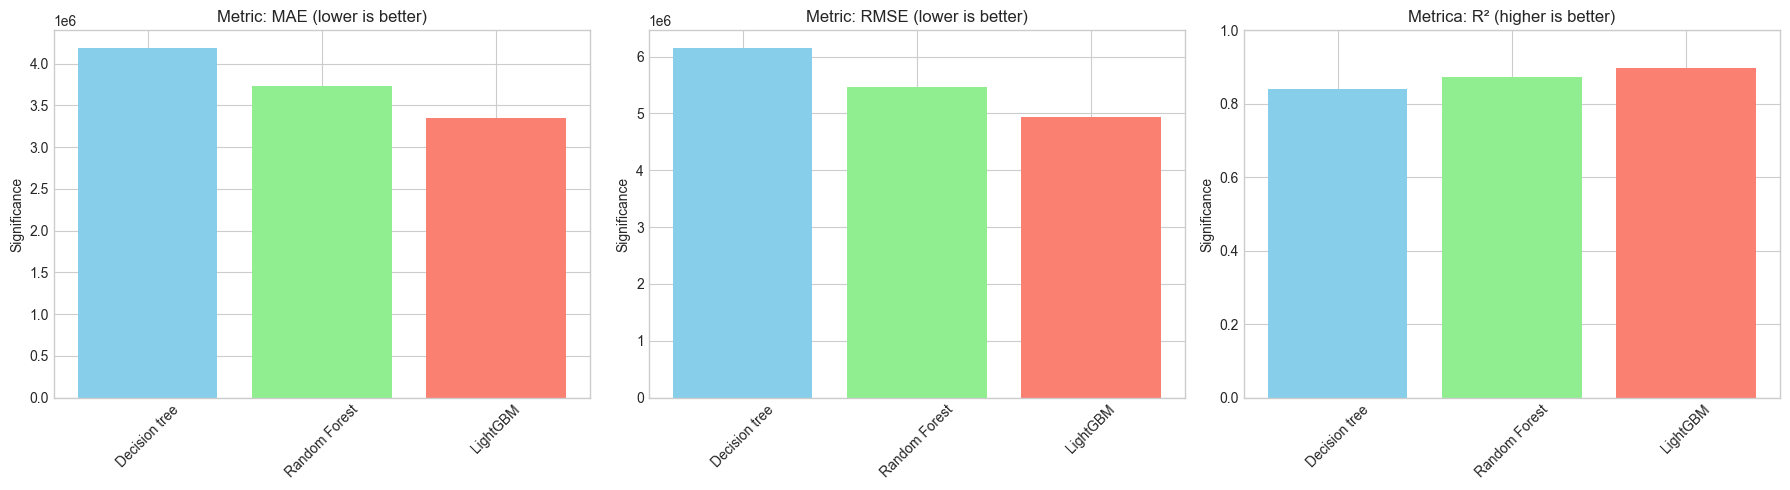

In [18]:
# Visualization of metrics
metrics = ['MAE', 'RMSE', 'R²']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    if metric == 'R²':
        # A value closer to 1 is better for R²
        axes[i].bar(results.index, results[metric], color=['skyblue', 'lightgreen', 'salmon'])
        axes[i].set_title(f'Metricа: {metric} (higher is better)')
        axes[i].set_ylim([0, 1])
    else:
        # For MAE and RMSE, a smaller value is better
        axes[i].bar(results.index, results[metric], color=['skyblue', 'lightgreen', 'salmon'])
        axes[i].set_title(f'Metric: {metric} (lower is better)')

    axes[i].set_ylabel('Significance')
    axes[i].set_xticklabels(results.index, rotation=45)

plt.tight_layout()
plt.show()

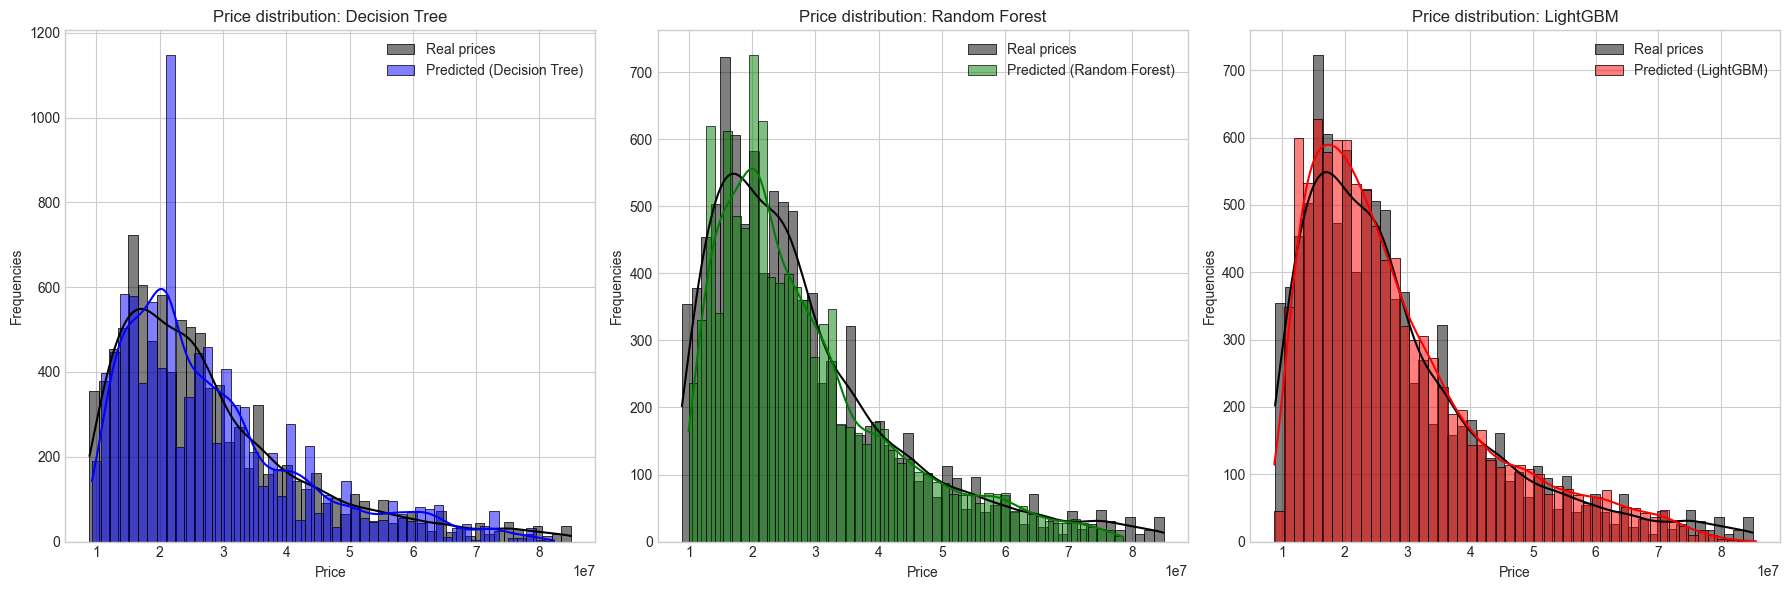

In [19]:
# Visualization of price distribution: true vs predicted
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models_predictions = {
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'LightGBM': y_pred_lgbm
}

colors = ['blue', 'green', 'red']

for i, (model_name, predictions) in enumerate(models_predictions.items()):
    sns.histplot(y_test, bins=50, kde=True, ax=axes[i], color='black', label='Real prices', alpha=0.5)
    sns.histplot(predictions, bins=50, kde=True, ax=axes[i], color=colors[i], label=f'Predicted ({model_name})', alpha=0.5)

    axes[i].set_title(f'Price distribution: {model_name}')
    axes[i].set_xlabel('Price')
    axes[i].set_ylabel('Frequencies')
    axes[i].legend()

plt.tight_layout()
plt.show()


## Model Training Time

Let's see how long it took each model to be trained.

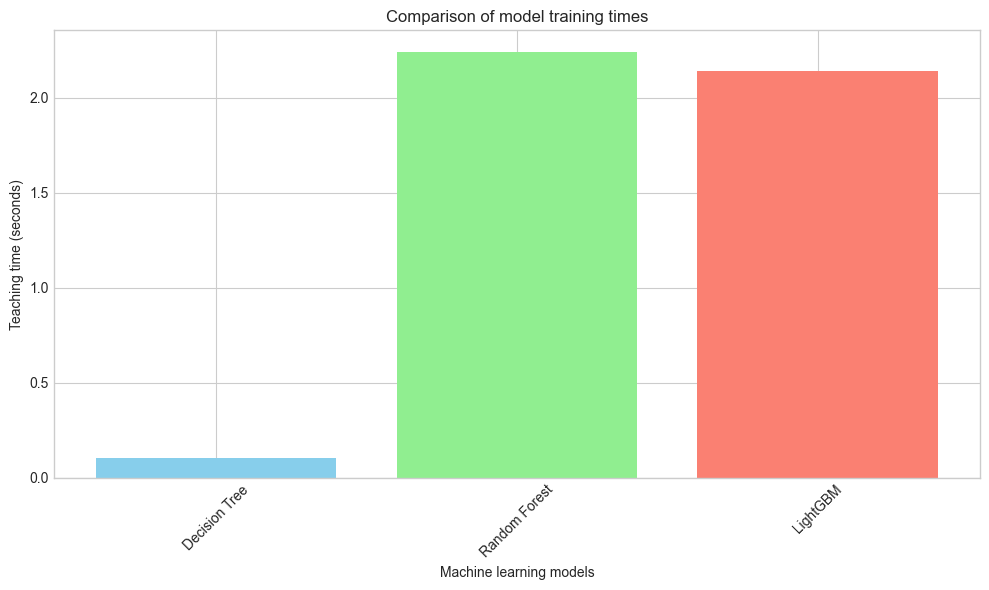

In [20]:
# Comparison of model training times
models_names = ['Decision Tree', 'Random Forest', 'LightGBM']
train_times = [train_time_dt, train_time_rf, train_time_lgbm]

plt.figure(figsize=(10, 6))
plt.bar(models_names, train_times, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Machine learning models')
plt.ylabel('Teaching time (seconds)')
plt.title('Comparison of model training times')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Visualizing the importance of attributes

Let's see which attributes most strongly influence property values in each of the models.

## Feature Importance

The model evaluates **how important each feature** is in predicting the price of an apartment.

---

### What is it?
It is the contribution of each feature to the final result.  
The **higher the importance**, the **stronger the impact** on the price.

---

### What is it for?
- To understand **what affects cost** the most.  
- Explain **why** the model made the prediction it did.  
- Optimize the data - you can remove **unnecessary features**.

---

**Feature Importance** helps you understand how a model **thinks** and make its performance **transparent**!

/var/folders/r1/ffz_5w253yz25hbl4kz193r00000gn/T/ipykernel_2251/3014630106.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Attribute', data=top_features, palette='viridis', ax=axes[i])
/var/folders/r1/ffz_5w253yz25hbl4kz193r00000gn/T/ipykernel_2251/3014630106.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Attribute', data=top_features, palette='viridis', ax=axes[i])
/var/folders/r1/ffz_5w253yz25hbl4kz193r00000gn/T/ipykernel_2251/3014630106.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x

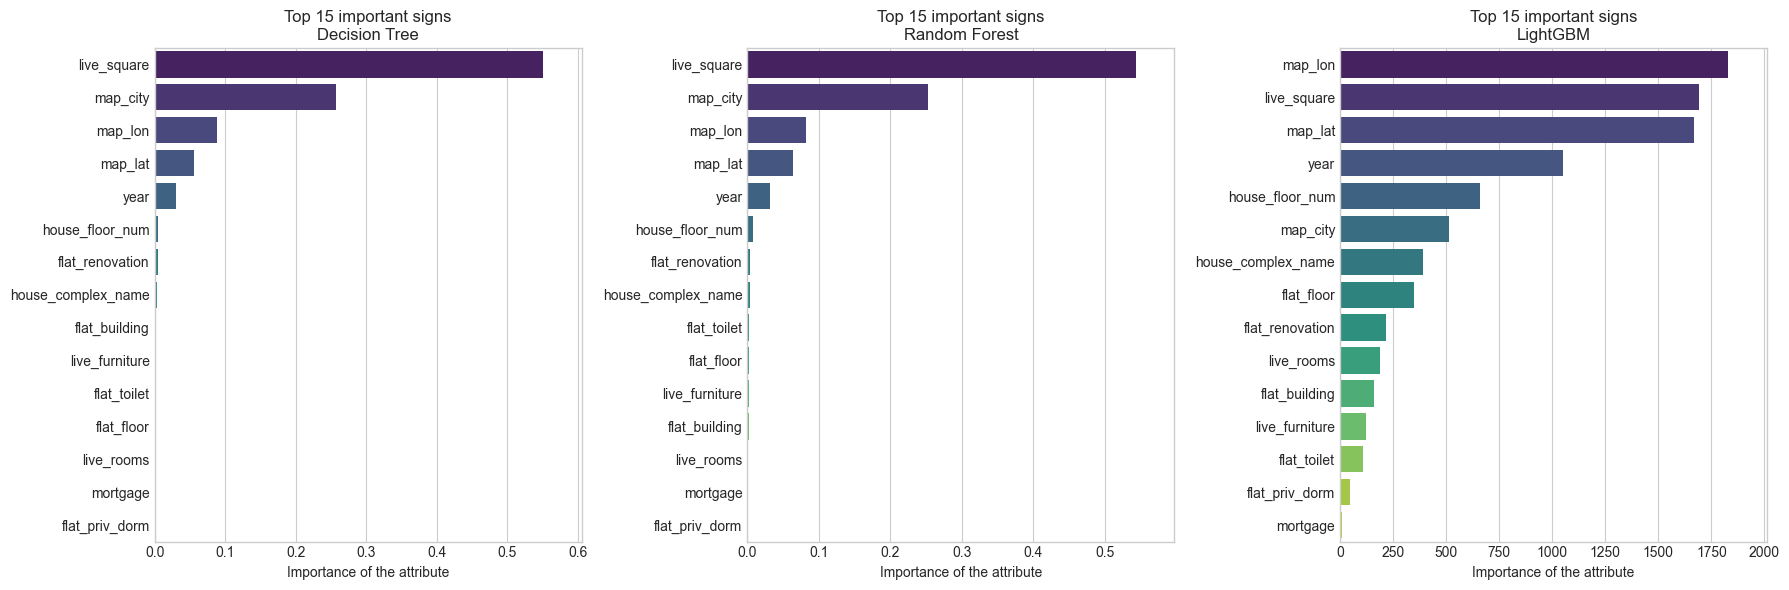

In [21]:
# Важность признаков для моделей
models_dict = {'Decision Tree': dt_model, 'Random Forest': rf_model, 'LightGBM': lgbm_model}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (model_name, model) in enumerate(models_dict.items()):
    feature_importances = model.feature_importances_
    feature_names = X.columns

    feature_importance_df = pd.DataFrame({
        'Attribute': feature_names,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)

    # Берем топ-15 признаков
    top_features = feature_importance_df.head(15)

    sns.barplot(x='Importance', y='Attribute', data=top_features, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Top 15 important signs\n{model_name}')
    axes[i].set_xlabel('Importance of the attribute')
    axes[i].set_ylabel('')
    axes[i].set_xlim(0, top_features['Importance'].max() * 1.1)

plt.tight_layout()
plt.show();

# Example of price prediction for one apartment

In [22]:

# Enter the parameters of the apartment
example = pd.DataFrame({
    'map_city': ['Алматы'],             # City
    'live_square': [45],                # Area of the apartment (sq.m.)
    'live_rooms': [2],                  # Number of rooms
    'house_complex_name': [1601],       # ID of the residential complex
    'map_lat': [51.25],                 # Geographic latitude
    'map_lon': [71.95],                 # Geographic longitude
    'year': [2005],                     # Year built
    'flat_floor': [5],                  # Floor of the apartment
    'house_floor_num': [9],             # Total number of floors in the building
    'flat_building': [1],               # Type of house (e.g. panelized, monolithic, etc.)
    'flat_renovation': [1],             # State of repair (e.g. unrepaired, euro, fresh, etc.)
    'live_furniture': [2],              # Furnishings (yes/no)
    'flat_toilet': [2],                 # Type of bathroom (combined/separate, etc.)
    'mortgage': [0],                    # Whether the apartment is mortgaged (0 - no, 1 - yes)
    'flat_priv_dorm': [2]               # Privatized dormitory (1 - no, 2 - yes)
})


# Coding the city (using the encoder trained earlier)
example['map_city'] = target_encoder.transform(example['map_city'])

# Prediction using the best model (LightGBM)
predicted_price = lgbm_model.predict(example)[0]

print(f"Expected price of the apartment: {predicted_price:,.0f} tenge")

Expected price of the apartment: 11,263,573 tenge


## Conclusions

#### Model Comparison:
1. **LightGBM** showed the best results with the highest R² and lowest errors (MAE, RMSE)
2. **Random Forest** is slightly inferior to LightGBM, but also gives good results
3. **Decision Tree** showed the worst results among the three models

### Important attributes:
The most important factors affecting real estate price were:
- Housing area
- Number of rooms
- Distance to the city center
- Age of the building

![photo_2025-04-20 17.36.56.jpeg](<attachment:photo_2025-04-20 17.36.56.jpeg>)
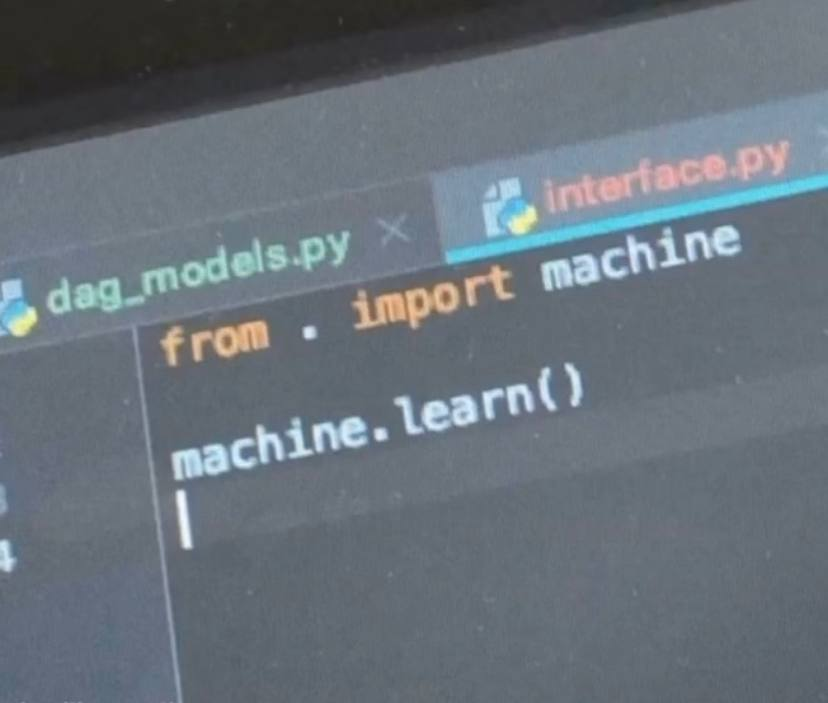